In [24]:
import os
import cv2
import numpy as np

def getImages(directorio, size=(256,256)):
    datos = []
    etiquetas = []
    for etiqueta, clase in enumerate(["fumador", "noFumador"]):
        pathClass = os.path.join(directorio, clase)
        for img in os.listdir(pathClass):
            imgPath = os.path.join(pathClass, img)
            imagen = cv2.imread(imgPath)
            if imagen is not None: 
                imagen = cv2.resize(imagen, size)
                datos.append(imagen)
                etiquetas.append(etiqueta)
    return (np.array(datos), np.array(etiquetas))

datos, etiquetas = getImages("data")

In [25]:
noFumadores = datos[etiquetas == 1]
fumadores = datos[etiquetas == 0]

print("No fumadores: ", noFumadores.shape)
print("Fumadores: ", fumadores.shape)

No fumadores:  (1276, 256, 256, 3)
Fumadores:  (1969, 256, 256, 3)


In [26]:
# Paso 2: Separar las clases
datos_fumadores = datos[etiquetas == 0]
etiquetas_fumadores = etiquetas[etiquetas == 0]

datos_no_fumadores = datos[etiquetas == 1]
etiquetas_no_fumadores = etiquetas[etiquetas == 1]

In [27]:
# Paso 3: Definir el número de muestras (tamaño mínimo de ambas clases)
n_samples = min(len(datos_fumadores), len(datos_no_fumadores))

In [28]:
# Paso 4: Reducir ambas clases al tamaño mínimo (undersampling)
from sklearn.utils import resample
datos_fumadores_reducidos, etiquetas_fumadores_reducidos = resample(
    datos_fumadores,
    etiquetas_fumadores,
    replace=False,
    n_samples=n_samples,
    random_state=42
)

In [29]:
datos_no_fumadores_reducidos, etiquetas_no_fumadores_reducidos = resample(
    datos_no_fumadores,
    etiquetas_no_fumadores,
    replace=False,
    n_samples=n_samples,
    random_state=42
)

In [30]:
# Paso 5: Concatenar los datos balanceados
datos = np.concatenate((datos_fumadores_reducidos, datos_no_fumadores_reducidos))
etiquetas = np.concatenate((etiquetas_fumadores_reducidos, etiquetas_no_fumadores_reducidos))

In [31]:

# Paso 6: Verificar el tamaño de cada clase
noFumadores = datos[etiquetas == 1]
fumadores = datos[etiquetas == 0]

In [32]:
print("No fumadores: ", noFumadores.shape)
print("Fumadores: ", fumadores.shape)

No fumadores:  (1276, 256, 256, 3)
Fumadores:  (1276, 256, 256, 3)


In [33]:
datos = datos / 255.0

In [34]:
from sklearn.model_selection import train_test_split
# Dividir datos en entrenamiento y validación (80% entrenamiento, 20% validación)
X_train, X_val, y_train, y_val = train_test_split(
    datos, 
    etiquetas, 
    test_size=0.2, 
    random_state=42
)

In [39]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception


# Cargar el modelo base ResNet50 preentrenado
base_model = Xception(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Añadir capas personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [40]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
import tensorflow as tf

# Verificar si hay GPUs disponibles
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU(s) disponible(s): {len(gpus)}")
else:
    print("No se detectaron GPUs.")

GPU(s) disponible(s): 1


In [42]:
from tensorflow.keras.callbacks import EarlyStopping

# Definir un callback para detener el entrenamiento si no mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/200


E0000 00:00:1731115076.504545    3443 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731115076.782170    3443 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-11-08 19:18:13.846894: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[64,128,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,128,125,125]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
E

11/32 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7004 - loss: 0.5880  

2024-11-08 19:18:28.862393: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[57,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[57,64,125,125]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-11-08 19:18:28.978680: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 15.752187759s
Trying algorithm eng3{k11=2} for conv (f32[57,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[57,64,125,125]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backen

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.7394 - loss: 0.5263

2024-11-08 19:18:48.884974: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[63,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[63,64,125,125]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
E0000 00:00:1731115113.748200    3439 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731115114.042708    3439 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7403 - loss: 0.5250 - val_accuracy: 0.7847 - val_loss: 0.4510
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8590 - loss: 0.3521 - val_accuracy: 0.8141 - val_loss: 0.4296
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.8865 - loss: 0.2800 - val_accuracy: 0.7886 - val_loss: 0.4774
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8894 - loss: 0.2751 - val_accuracy: 0.8180 - val_loss: 0.4430
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8995 - loss: 0.2474 - val_accuracy: 0.8219 - val_loss: 0.4445
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.9341 - loss: 0.1849 - val_accuracy: 0.8258 - val_loss: 0.4271
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.9485 - loss: 0.1578 - val_accuracy: 0.8082 - val_loss: 0.5314
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.9482 - loss: 0.1531 - val_accuracy: 0.8004 -

In [43]:
model.save('v6.keras')

In [44]:
import tensorflow as tf

In [45]:
modeloGuardado = tf.keras.models.load_model('resnet.keras')

In [46]:

import cv2
import numpy as np

def predecir_fumador(ruta_imagen, modelo):
    # Cargar la imagen desde la ruta especificada
    imagen = cv2.imread(ruta_imagen)
    
    if imagen is None:
        print(f"No se pudo cargar la imagen en {ruta_imagen}. Asegúrate de que la ruta sea correcta.")
        return
    
    # Preprocesar la imagen: redimensionar y normalizar
    imagen = cv2.resize(imagen, (256, 256))  # Redimensionar al tamaño esperado por el modelo
    imagen = imagen / 255.0  # Normalizar al rango [0, 1]
    imagen = np.expand_dims(imagen, axis=0)  # Añadir una dimensión para representar el batch (1, 256, 256, 3)

    # Realizar la predicción
    prediccion = modelo.predict(imagen)
    
    # Interpretar la predicción
    if prediccion[0][0] > 0.5:
        resultado = "No fumador"
    else:
        resultado = "Fumador"
    
    # Mostrar el resultado
    print(f"Resultado de la predicción para la imagen {ruta_imagen}: {resultado}")
    return resultado

In [47]:
fumador = 'data/fumador/000-0.jpg'
nofumador = 'data/noFumador/000296.jpg'

predecir_fumador(nofumador, modeloGuardado)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Resultado de la predicción para la imagen data/noFumador/000296.jpg: Fumador


'Fumador'

In [48]:
import os
import cv2
import numpy as np

def getImages(directorio, size=(256,256)):
    datos = []
    etiquetas = []
    for etiqueta, clase in enumerate(["fumador", "noFumador"]):
        pathClass = os.path.join(directorio, clase)
        for img in os.listdir(pathClass):
            imgPath = os.path.join(pathClass, img)
            imagen = cv2.imread(imgPath)
            if imagen is not None: 
                imagen = cv2.resize(imagen, size)
                datos.append(imagen)
                etiquetas.append(etiqueta)
    return (np.array(datos), np.array(etiquetas))

# Cargar los datos
datos, etiquetas = getImages("data")

# Normalizar los datos
datos = datos / 255.0

from sklearn.model_selection import train_test_split

# Dividir datos en entrenamiento y validación (80% entrenamiento, 20% validación)
X_train, X_val, y_train, y_val = train_test_split(
    datos, 
    etiquetas, 
    test_size=0.2, 
    random_state=42
)

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step
Reporte de Clasificación:
               precision    recall  f1-score   support

     Fumador       0.81      0.71      0.76       428
  No Fumador       0.54      0.67      0.60       221

    accuracy                           0.70       649
   macro avg       0.68      0.69      0.68       649
weighted avg       0.72      0.70      0.70       649



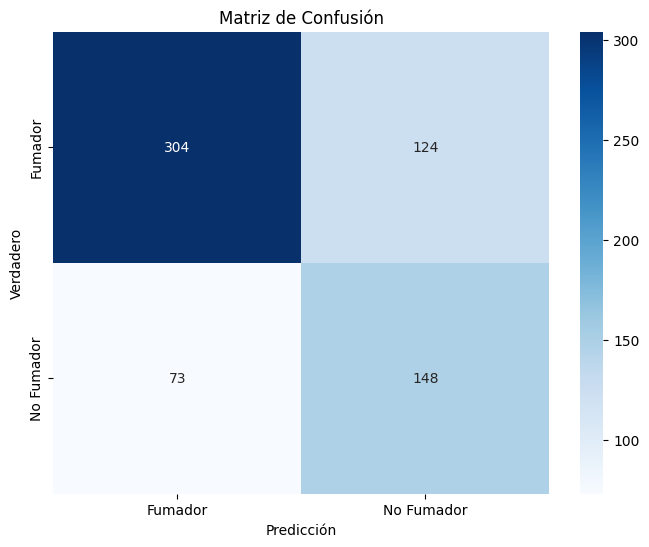

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predecir las probabilidades en los datos de validación
predicciones_proba = modeloGuardado.predict(X_val)

# Convertir probabilidades en etiquetas (umbral = 0.5)
predicciones = (predicciones_proba > 0.5).astype(int).flatten()

# Generar el reporte de clasificación
reporte = classification_report(y_val, predicciones, target_names=["Fumador", "No Fumador"])
print("Reporte de Clasificación:\n", reporte)

# Generar la matriz de confusión
matriz_confusion = confusion_matrix(y_val, predicciones)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=["Fumador", "No Fumador"], yticklabels=["Fumador", "No Fumador"])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()